<a href="https://colab.research.google.com/github/gsahonero/Talks-Presentations/blob/main/IUII-Nov-25/PyPulseq_T1w_T2w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Simple PyPulseq notebook for GRE sequence generation. Basically the same code from: https://github.com/imr-framework/pypulseq/blob/master/examples/scripts/write_gre.py

In [ ]:
!pip install pypulseq

Timing check passed successfully


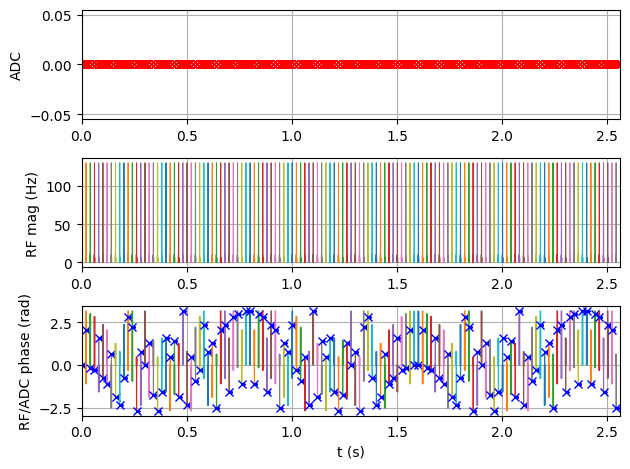

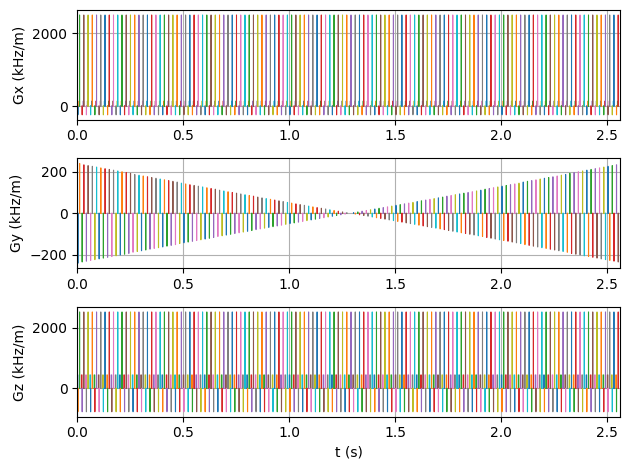

Number of blocks: 640
Number of events:
RF:    128
Gx:    384
Gy:    256
Gz:    384
ADC:    128
Delay:      0
Sequence duration: 2.560000 s
TE: 0.008000 s
TR: 0.020000 s
Flip angle: 35.00 deg
Unique k-space positions (aka cols, rows, etc.): 128 128 
Dimensions: 2
Spatial resolution: 2.36 mm
Spatial resolution: 2.34 mm
Repetitions/slices/contrasts: 1.0; range: [(1.0, 1.0)]
Cartesian encoding trajectory detected
Event timing check passed successfully
Max gradient: 2509804 239700 2515723 Hz/m == 58.95 5.63 59.09 mT/m
Max slew rate: 20915032680 2333333333 20964360587 Hz/m/s == 491.24 54.80 492.40 T/m/s
Max absolute gradient: 3561662 Hz/m == 83.65 mT/m
Max absolute slew rate: 2.9705e+10 Hz/m/s == 697.69 T/m/s


In [11]:
import math

import numpy as np

import pypulseq as pp

plot = True
write_seq = True
seq_filename = "gre_pypulseq.seq"

# ======
# SETUP
# ======
# Create a new sequence object
fov = 0.3  # Define FOV and resolution
Nx = 128
Ny = 128
alpha = 35  # flip angle
slice_thickness = 3e-3  # slice
TR = 20e-3  # Repetition time
TE = 8e-3  # Echo time

rf_spoiling_inc = 117  # RF spoiling increment

system = pp.Opts(
    max_grad=60,
    grad_unit='mT/m',
    max_slew=500,
    slew_unit='T/m/s',
    rf_ringdown_time=20e-6,
    rf_dead_time=100e-6,
    adc_dead_time=10e-6,
)

seq = pp.Sequence(system)

# ======
# CREATE EVENTS
# ======
rf, gz, _ = pp.make_sinc_pulse(
    flip_angle=alpha * math.pi / 180,
    duration=3e-3,
    slice_thickness=slice_thickness,
    apodization=0.42,
    time_bw_product=4,
    system=system,
    return_gz=True,
    delay=system.rf_dead_time,
)
# Define other gradients and ADC events
delta_k = 1 / fov
gx = pp.make_trapezoid(channel='x', flat_area=Nx * delta_k, flat_time=3.2e-3, system=system)
adc = pp.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)
gz_reph = pp.make_trapezoid(channel='z', area=-gz.area / 2, duration=1e-3, system=system)
phase_areas = (np.arange(Ny) - Ny / 2) * delta_k

# gradient spoiling
gx_spoil = pp.make_trapezoid(channel='x', area=2 * Nx * delta_k, system=system)
gz_spoil = pp.make_trapezoid(channel='z', area=4 / slice_thickness, system=system)

# Calculate timing
delay_TE = (
    math.ceil(
        (
            TE
            - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
            - pp.calc_duration(gx_pre)
            - pp.calc_duration(gx) / 2
            - pp.eps
        )
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)
delay_TR = (
    np.ceil(
        (TR - pp.calc_duration(gz, rf) - pp.calc_duration(gx_pre) - pp.calc_duration(gx) - delay_TE)
        / seq.grad_raster_time
    )
    * seq.grad_raster_time
)

assert np.all(delay_TE >= 0)
assert np.all(delay_TR >= pp.calc_duration(gx_spoil, gz_spoil))

rf_phase = 0
rf_inc = 0

# ======
# CONSTRUCT SEQUENCE
# ======
# Loop over phase encodes and define sequence blocks
for i in range(Ny):
    rf.phase_offset = rf_phase / 180 * np.pi
    adc.phase_offset = rf_phase / 180 * np.pi
    rf_inc = divmod(rf_inc + rf_spoiling_inc, 360.0)[1]
    rf_phase = divmod(rf_phase + rf_inc, 360.0)[1]

    seq.add_block(rf, gz)
    gy_pre = pp.make_trapezoid(
        channel='y',
        area=phase_areas[i],
        duration=pp.calc_duration(gx_pre),
        system=system,
    )
    seq.add_block(gx_pre, gy_pre, gz_reph)
    seq.add_block(pp.make_delay(delay_TE))
    seq.add_block(gx, adc)
    gy_pre.amplitude = -gy_pre.amplitude
    seq.add_block(pp.make_delay(delay_TR), gx_spoil, gy_pre, gz_spoil)

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# ======
# VISUALIZATION
# ======
if plot:
    seq.plot()

seq.calculate_kspace()

# Very optional slow step, but useful for testing during development e.g. for the real TE, TR or for staying within
# slew-rate limits
rep = seq.test_report()
print(rep)

# =========
# WRITE .SEQ
# =========
if write_seq:
    # Prepare the sequence output for the scanner
    seq.set_definition(key='FOV', value=[fov, fov, slice_thickness])
    seq.set_definition(key='Name', value='gre')

    seq.write(seq_filename)
